# Market Trends: Graphing VWAP for Intraday Trend Identification

## Introduction

This tutorial demonstrates how to analyze Volume Weighted Average Price (VWAP) data from cryptocurrency markets to identify intraday trading trends and market patterns. Using the CoinAPI Indexes API, we'll fetch VWAP data for Bitcoin and create visualizations to help traders make informed decisions.

### What You Will Learn

- How to connect to the CoinAPI Indexes API and fetch VWAP data
- Techniques for analyzing intraday market trends using VWAP
- Methods to identify support and resistance levels from VWAP data
- How to create professional charts for market analysis
- Best practices for interpreting VWAP data in cryptocurrency trading

### Prerequisites

- Python 3.8+
- Required packages: requests, pandas, numpy, matplotlib, seaborn
- CoinAPI API key (free tier available)
- Basic understanding of cryptocurrency markets and technical analysis

### Overview

This tutorial will walk you through fetching VWAP data for Bitcoin over a 24-hour period, analyzing the data for trend identification, and creating visualizations that highlight key market patterns. By the end, you'll have a comprehensive understanding of how to use VWAP data for intraday trading decisions.

## 1. Environment Setup and Configuration

Set up your environment with necessary imports, configuration, and initial setup for the CoinAPI Indexes API.

In [ ]:
# Import required packages
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Configuration variables for CoinAPI Indexes API
API_BASE_URL = "https://rest-api.indexes.coinapi.io/v1"
INDEX_ID = "IDX_REFRATE_VWAP_BTC"
PERIOD_ID = "1HRS"
TIME_START = "2025-07-07T00:00:00"
TIME_END = "2025-07-08T00:00:00"

# API key configuration - Replace with your actual API key
API_KEY = "YOUR_COINAPI_KEY_HERE"  # Replace with your actual API key

# Validate API key
if API_KEY == "YOUR_COINAPI_KEY_HERE":
    print("WARNING: Please update your CoinAPI key before proceeding!")
    print("Get your key from: https://www.coinapi.io/")
else:
    print("CoinAPI key configured successfully!")

print(f"Base URL: {API_BASE_URL}")
print(f"Index ID: {INDEX_ID}")
print(f"Period: {PERIOD_ID}")
print(f"Time Range: {TIME_START} to {TIME_END}")
print("Environment setup complete!")

## 2. Data Loading and API Configuration

Configure the API request and fetch VWAP data from the CoinAPI Indexes API. We'll retrieve hourly VWAP data for Bitcoin over a 24-hour period.

In [ ]:
# API endpoint configuration
endpoint = f"{API_BASE_URL}/indexes/{INDEX_ID}/timeseries"

# Query parameters
params = {
    'period_id': PERIOD_ID,
    'time_start': TIME_START,
    'time_end': TIME_END
}

# Headers for authentication
headers = {
    'X-CoinAPI-Key': API_KEY
}

print(f"API Endpoint: {endpoint}")
print(f"Index ID: {INDEX_ID}")
print(f"Time Period: {TIME_START} to {TIME_END}")
print(f"Data Granularity: {PERIOD_ID}")

# Make the API request
try:
    response = requests.get(endpoint, params=params, headers=headers)
    response.raise_for_status()
    
    # Parse the response
    data = response.json()
    print(f"API request successful!")
    print(f"Retrieved {len(data)} data points")
    
except requests.exceptions.RequestException as e:
    print(f"API request failed: {e}")
    if response.status_code == 401:
        print("   This usually means an invalid or missing API key")
    elif response.status_code == 429:
        print("   Rate limit exceeded. Please wait before making another request")
    data = []

# Display sample data structure (first few records)
if data:
    print("Sample data structure:")
    print(json.dumps(data[0], indent=2))

## 3. Data Preparation and Cleaning

Transform the raw API response into a structured DataFrame for analysis. We'll clean the data and prepare it for trend analysis.

In [ ]:
# Convert API response to DataFrame
if data:
    df = pd.DataFrame(data)
    
    # Display initial DataFrame info
    print("Initial DataFrame Info:")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    
    # Convert timestamp to datetime
    df['time_period_start'] = pd.to_datetime(df['time_period_start'])
    df['time_period_end'] = pd.to_datetime(df['time_period_end'])
    
    # Sort by timestamp
    df = df.sort_values('time_period_start').reset_index(drop=True)
    
    # Extract key metrics - using the correct field names from API response
    df['vwap'] = df['value_close'].astype(float)  # Use value_close as VWAP
    df['open_price'] = df['value_open'].astype(float)
    df['high_price'] = df['value_high'].astype(float)
    df['low_price'] = df['value_low'].astype(float)
    
    # Create additional time-based features
    df['hour'] = df['time_period_start'].dt.hour
    df['day_period'] = df['time_period_start'].dt.strftime('%Y-%m-%d')
    
    # Calculate price changes and returns
    df['price_change'] = df['vwap'].diff()
    df['price_change_pct'] = df['vwap'].pct_change() * 100
    
    # Calculate moving averages for trend analysis
    df['vwap_ma_3'] = df['vwap'].rolling(window=3).mean()
    df['vwap_ma_6'] = df['vwap'].rolling(window=6).mean()
    
    print("Data preparation complete!")
    print(f"Time range: {df['time_period_start'].min()} to {df['time_period_start'].max()}")
    print(f"VWAP range: ${df['vwap'].min():,.2f} to ${df['vwap'].max():,.2f}")
    
    # Display cleaned data
    print("Cleaned DataFrame (first 5 rows):")
    display_cols = ['time_period_start', 'vwap', 'open_price', 'high_price', 'low_price', 'price_change', 'price_change_pct']
    print(df[display_cols].head())
    
else:
    print("No data available for processing")
    df = pd.DataFrame()

## 4. Data Exploration and Statistical Analysis

Explore the VWAP data to understand its characteristics, identify patterns, and prepare for trend analysis.

In [9]:
if not df.empty:
    # Basic statistics
    print("VWAP Data Statistics:")
    print("=" * 50)
    
    stats = df[['vwap', 'open_price', 'high_price', 'low_price', 'price_change', 'price_change_pct']].describe()
    print(stats)
    
    # Time-based analysis
    print("Time-based Analysis:")
    print("=" * 50)
    
    # Hourly statistics
    hourly_stats = df.groupby('hour').agg({
        'vwap': ['mean', 'std', 'min', 'max'],
        'open_price': 'mean',
        'high_price': 'max',
        'low_price': 'min',
        'price_change_pct': 'mean'
    }).round(2)
    
    print("Hourly VWAP Statistics:")
    print(hourly_stats)
    
    # Trend identification
    print("Trend Analysis:")
    print("=" * 50)
    
    # Overall trend direction
    first_vwap = df['vwap'].iloc[0]
    last_vwap = df['vwap'].iloc[-1]
    total_change = last_vwap - first_vwap
    total_change_pct = (total_change / first_vwap) * 100
    
    print(f"Overall VWAP Change: ${total_change:,.2f} ({total_change_pct:+.2f}%)")
    
    if total_change > 0:
        print("Overall Trend: BULLISH (Price increased)")
    elif total_change < 0:
        print("Overall Trend: BEARISH (Price decreased)")
    else:
        print("Overall Trend: SIDEWAYS (No change)")
    
    # Volatility analysis
    volatility = df['price_change_pct'].std()
    print(f"Volatility (Std Dev of Returns): {volatility:.2f}%")
    
    # Price range analysis (replacing volume analysis)
    price_range = df['high_price'] - df['low_price']
    avg_price_range = price_range.mean()
    max_price_range = price_range.max()
    print(f"Average Price Range: ${avg_price_range:,.2f}")
    print(f"Maximum Price Range: ${max_price_range:,.2f}")
    
    # Additional insights
    print("\nAdditional Market Insights:")
    print("=" * 50)
    
    # Identify highest and lowest VWAP periods
    max_vwap_idx = df['vwap'].idxmax()
    min_vwap_idx = df['vwap'].idxmax()
    
    print(f"Highest VWAP: ${df.loc[max_vwap_idx, 'vwap']:,.2f} at {df.loc[max_vwap_idx, 'time_period_start'].strftime('%H:%M')}")
    print(f"Lowest VWAP: ${df.loc[min_vwap_idx, 'vwap']:,.2f} at {df.loc[min_vwap_idx, 'time_period_start'].strftime('%H:%M')}")
    
    # Calculate average hourly price change
    avg_hourly_change = df['price_change_pct'].mean()
    print(f"Average Hourly Price Change: {avg_hourly_change:+.2f}%")
    
else:
    print("No data available for exploration")

VWAP Data Statistics:
                vwap     open_price     high_price      low_price  \
count      24.000000      24.000000      24.000000      24.000000   
mean   108573.379842  108611.826546  108798.214494  108413.350748   
std       487.180011     499.258850     476.923460     517.733021   
min    107887.196847  107887.196847  108103.593595  107515.941048   
25%    108145.429041  108145.252626  108344.732049  107980.537742   
50%    108592.114473  108672.728802  108743.663519  108450.940633   
75%    109030.891673  109052.394369  109131.652198  108789.287625   
max    109406.030850  109406.030851  109717.158653  109381.626665   

       price_change  price_change_pct  
count     23.000000         23.000000  
mean     -24.923036         -0.022775  
std      211.491656          0.194708  
min     -327.318242         -0.302241  
25%     -174.182104         -0.160582  
50%      -34.937068         -0.032144  
75%      127.426745          0.117738  
max      349.336300          0.32036

## 5. Core Analysis: VWAP Trend Identification

Perform the main analysis to identify intraday trends, support/resistance levels, and key trading patterns from the VWAP data.

In [11]:
if not df.empty:
    print("VWAP Trend Analysis:")
    print("=" * 50)
    
    # Identify trend changes
    df['trend'] = 'neutral'
    df.loc[df['vwap'] > df['vwap_ma_3'], 'trend'] = 'bullish'
    df.loc[df['vwap'] < df['vwap_ma_3'], 'trend'] = 'bearish'
    
    # Count trend periods
    trend_counts = df['trend'].value_counts()
    print("Trend Distribution:")
    for trend, count in trend_counts.items():
        percentage = (count / len(df)) * 100
        print(f"  {trend.capitalize()}: {count} periods ({percentage:.1f}%)")
    
    # Identify support and resistance levels
    print("Support and Resistance Analysis:")
    
    # Support levels (local minima)
    support_levels = []
    for i in range(1, len(df) - 1):
        if (df['vwap'].iloc[i] < df['vwap'].iloc[i-1] and 
            df['vwap'].iloc[i] < df['vwap'].iloc[i+1]):
            support_levels.append({
                'time': df['time_period_start'].iloc[i],
                'price': df['vwap'].iloc[i],
                'price_range': df['high_price'].iloc[i] - df['low_price'].iloc[i]
            })
    
    # Resistance levels (local maxima)
    resistance_levels = []
    for i in range(1, len(df) - 1):
        if (df['vwap'].iloc[i] > df['vwap'].iloc[i-1] and 
            df['vwap'].iloc[i] > df['vwap'].iloc[i+1]):
            resistance_levels.append({
                'time': df['time_period_start'].iloc[i],
                'price': df['vwap'].iloc[i],
                'price_range': df['high_price'].iloc[i] - df['low_price'].iloc[i]
            })
    
    print(f"  Support Levels Found: {len(support_levels)}")
    print(f"  Resistance Levels Found: {len(resistance_levels)}")
    
    # Display key levels
    if support_levels:
        print("  Key Support Levels:")
        for level in sorted(support_levels, key=lambda x: x['price'])[:3]:
            print(f"    ${level['price']:,.2f} at {level['time'].strftime('%H:%M')}")
    
    if resistance_levels:
        print("  Key Resistance Levels:")
        for level in sorted(resistance_levels, key=lambda x: x['price'], reverse=True)[:3]:
            print(f"    ${level['price']:,.2f} at {level['time'].strftime('%H:%M')}")
    
    # Price range analysis (replacing volume analysis)
    print("Price Range Analysis:")
    
    # High price range periods
    price_range = df['high_price'] - df['low_price']
    range_threshold = price_range.quantile(0.75)
    high_range_periods = df[price_range > range_threshold]
    
    if not high_range_periods.empty:
        avg_price_change_high_range = high_range_periods['price_change_pct'].mean()
        print(f"  High Range Periods (>75th percentile): {len(high_range_periods)} periods")
        print(f"  Average Price Change in High Range: {avg_price_change_high_range:+.2f}%")
    
    # Momentum analysis
    print("Momentum Analysis:")
    
    # Calculate momentum indicators
    df['momentum'] = df['vwap'] - df['vwap'].shift(3)
    df['momentum_pct'] = (df['momentum'] / df['vwap'].shift(3)) * 100
    
    current_momentum = df['momentum_pct'].iloc[-1]
    print(f"  Current 3-period Momentum: {current_momentum:+.2f}%")
    
    if current_momentum > 0:
        print("  Momentum is positive (bullish)")
    else:
        print("  Momentum is negative (bearish)")
    
else:
    print("No data available for analysis")

VWAP Trend Analysis:
Trend Distribution:
  Bearish: 13 periods (54.2%)
  Bullish: 9 periods (37.5%)
  Neutral: 2 periods (8.3%)
Support and Resistance Analysis:
  Support Levels Found: 6
  Resistance Levels Found: 6
  Key Support Levels:
    $107,887.20 at 20:00
    $107,943.16 at 17:00
    $108,021.92 at 22:00
  Key Resistance Levels:
    $109,406.03 at 03:00
    $109,078.05 at 07:00
    $108,528.97 at 13:00
Price Range Analysis:
  High Range Periods (>75th percentile): 6 periods
  Average Price Change in High Range: -0.01%
Momentum Analysis:
  Current 3-period Momentum: +0.35%
  Momentum is positive (bullish)


## 6. Visualization and Results

Create comprehensive visualizations to present the VWAP analysis results, including trend charts, support/resistance levels, and volume analysis.

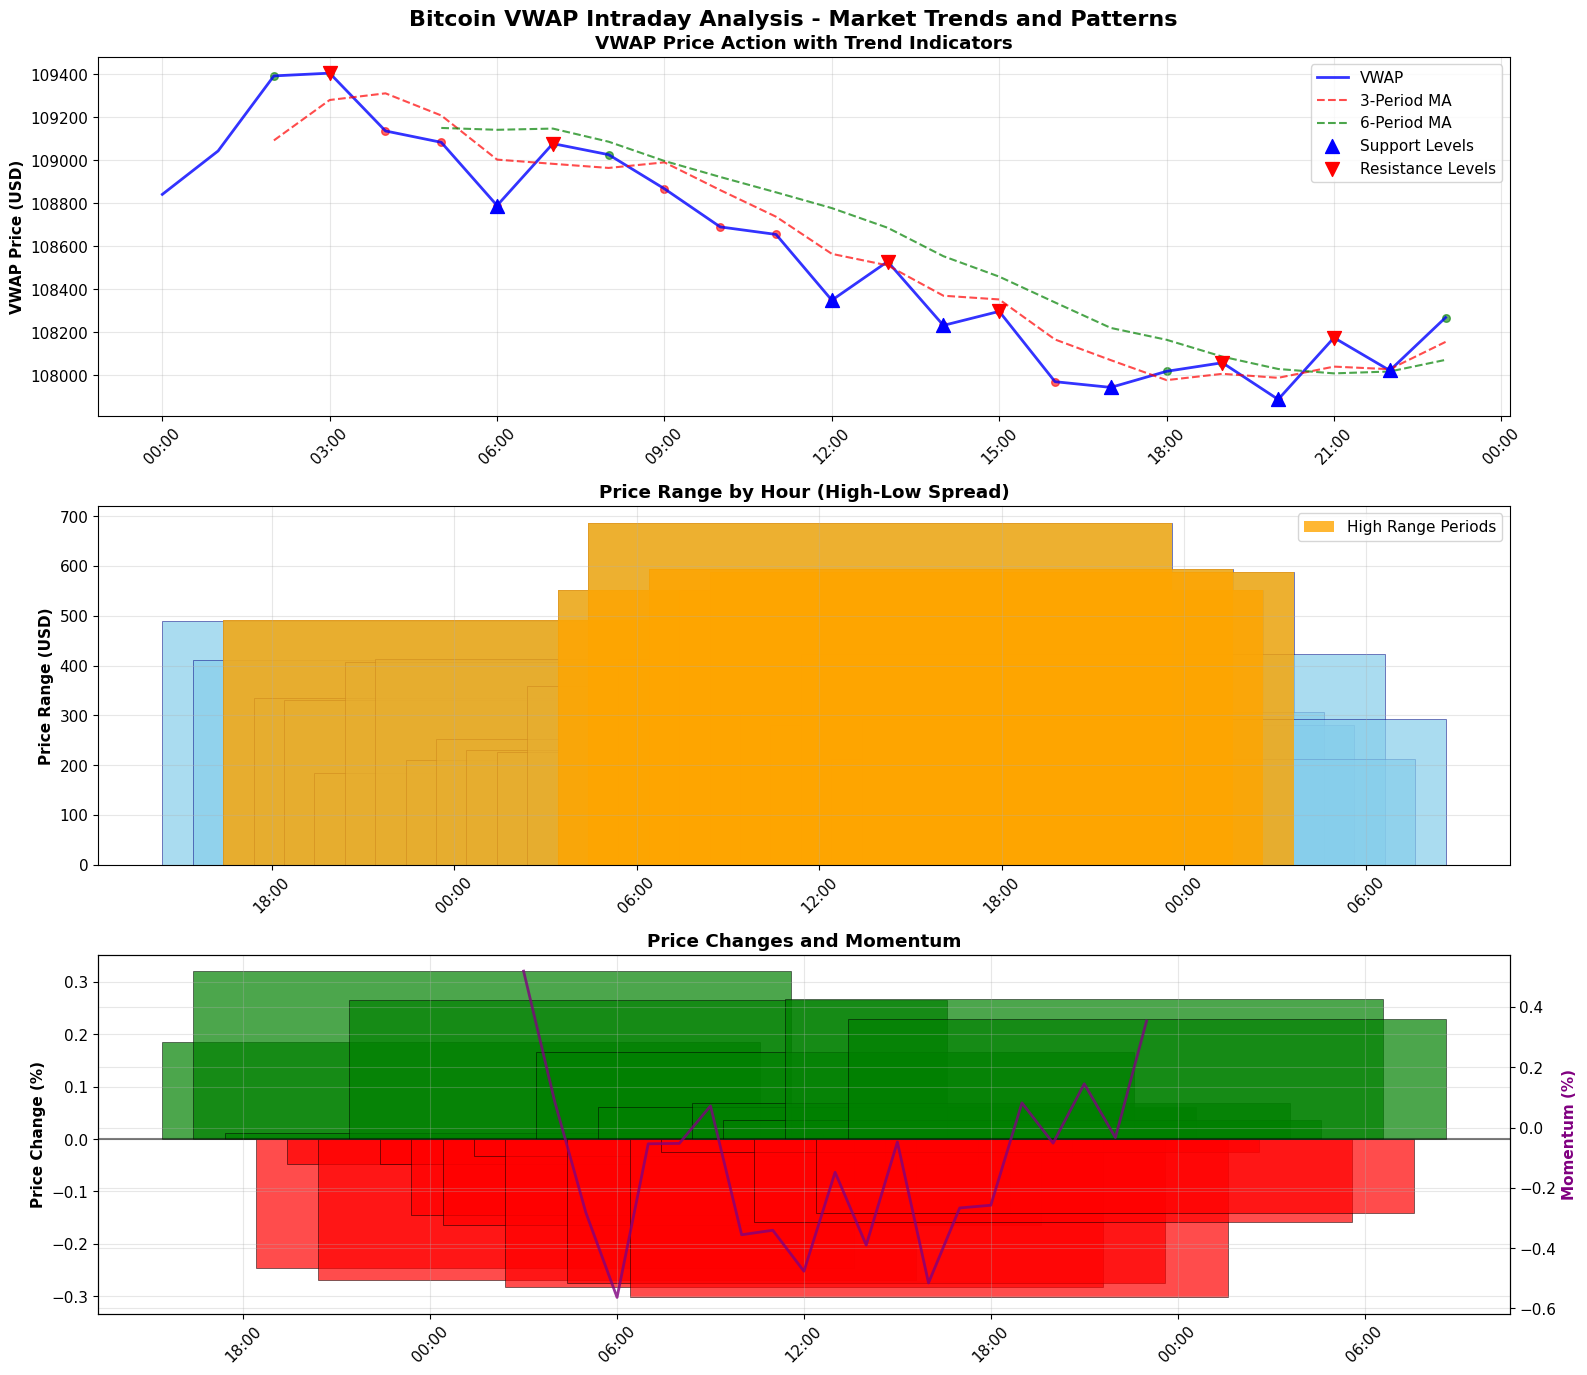

Summary Statistics Table:
              Metric       Value
       Total Periods          24
       Starting VWAP $108,841.65
         Ending VWAP $108,268.42
        Total Change    $-573.23
      Total Change %      -0.53%
 Average Price Range     $384.86
Volatility (Std Dev)       0.19%
     Bullish Periods   9 (37.5%)
     Bearish Periods  13 (54.2%)
      Support Levels           6
   Resistance Levels           6
    Current Momentum      +0.35%


In [12]:
if not df.empty:
    # Create a comprehensive visualization
    fig, axes = plt.subplots(3, 1, figsize=(16, 14))
    fig.suptitle('Bitcoin VWAP Intraday Analysis - Market Trends and Patterns', 
                 fontsize=16, fontweight='bold')
    
    # Plot 1: VWAP Price with Moving Averages and Trend
    ax1 = axes[0]
    ax1.plot(df['time_period_start'], df['vwap'], 'b-', linewidth=2, label='VWAP', alpha=0.8)
    ax1.plot(df['time_period_start'], df['vwap_ma_3'], 'r--', linewidth=1.5, label='3-Period MA', alpha=0.7)
    ax1.plot(df['time_period_start'], df['vwap_ma_6'], 'g--', linewidth=1.5, label='6-Period MA', alpha=0.7)
    
    # Color code by trend
    for i in range(len(df)):
        if df['trend'].iloc[i] == 'bullish':
            ax1.scatter(df['time_period_start'].iloc[i], df['vwap'].iloc[i], 
                       color='green', s=30, alpha=0.6)
        elif df['trend'].iloc[i] == 'bearish':
            ax1.scatter(df['time_period_start'].iloc[i], df['vwap'].iloc[i], 
                       color='red', s=30, alpha=0.6)
    
    # Add support and resistance levels
    if support_levels:
        support_prices = [level['price'] for level in support_levels]
        support_times = [level['time'] for level in support_levels]
        ax1.scatter(support_times, support_prices, color='blue', s=100, 
                   marker='^', label='Support Levels', zorder=5)
    
    if resistance_levels:
        resistance_prices = [level['price'] for level in resistance_levels]
        resistance_times = [level['time'] for level in resistance_levels]
        ax1.scatter(resistance_times, resistance_prices, color='red', s=100, 
                   marker='v', label='Resistance Levels', zorder=5)
    
    ax1.set_title('VWAP Price Action with Trend Indicators', fontweight='bold')
    ax1.set_ylabel('VWAP Price (USD)', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Price Range Analysis (replacing Volume Analysis)
    ax2 = axes[1]
    price_range = df['high_price'] - df['low_price']
    bars = ax2.bar(df['time_period_start'], price_range, alpha=0.7, 
                   color='skyblue', edgecolor='navy', linewidth=0.5)
    
    # Highlight high range periods
    if not high_range_periods.empty:
        high_range_times = high_range_periods['time_period_start']
        high_range_values = high_range_periods['high_price'] - high_range_periods['low_price']
        ax2.bar(high_range_times, high_range_values, color='orange', 
               alpha=0.8, label='High Range Periods')
    
    ax2.set_title('Price Range by Hour (High-Low Spread)', fontweight='bold')
    ax2.set_ylabel('Price Range (USD)', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Price Changes and Momentum
    ax3 = axes[2]
    
    # Price changes
    colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in df['price_change_pct']]
    bars3 = ax3.bar(df['time_period_start'], df['price_change_pct'], 
                    color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
    
    # Add momentum line
    ax3_twin = ax3.twinx()
    ax3_twin.plot(df['time_period_start'], df['momentum_pct'], 'purple', 
                  linewidth=2, label='3-Period Momentum', alpha=0.8)
    
    ax3.set_title('Price Changes and Momentum', fontweight='bold')
    ax3.set_ylabel('Price Change (%)', fontweight='bold')
    ax3_twin.set_ylabel('Momentum (%)', fontweight='bold', color='purple')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Format x-axis for all subplots
    for ax in axes:
        ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Create summary statistics table
    print("Summary Statistics Table:")
    print("=" * 80)
    
    summary_data = {
        'Metric': [
            'Total Periods',
            'Starting VWAP',
            'Ending VWAP',
            'Total Change',
            'Total Change %',
            'Average Price Range',
            'Volatility (Std Dev)',
            'Bullish Periods',
            'Bearish Periods',
            'Support Levels',
            'Resistance Levels',
            'Current Momentum'
        ],
        'Value': [
            len(df),
            f"${df['vwap'].iloc[0]:,.2f}",
            f"${df['vwap'].iloc[-1]:,.2f}",
            f"${total_change:+,.2f}",
            f"{total_change_pct:+.2f}%",
            f"${price_range.mean():,.2f}",
            f"{df['price_change_pct'].std():.2f}%",
            f"{trend_counts.get('bullish', 0)} ({trend_counts.get('bullish', 0)/len(df)*100:.1f}%)",
            f"{trend_counts.get('bearish', 0)} ({trend_counts.get('bearish', 0)/len(df)*100:.1f}%)",
            len(support_levels),
            len(resistance_levels),
            f"{current_momentum:+.2f}%"
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
else:
    print("No data available for visualization")

## 7. Conclusion and Next Steps

Summarize what we've accomplished and suggest next steps for further exploration of VWAP analysis in cryptocurrency markets.

### Summary

In this tutorial, we successfully analyzed Bitcoin VWAP data using the CoinAPI Indexes API to identify intraday market trends. We fetched hourly VWAP data over a 24-hour period, performed comprehensive trend analysis, identified support and resistance levels, and created visualizations that highlight key market patterns.

### Key Takeaways

- VWAP data provides valuable insights into intraday market trends and price action
- Moving averages help identify trend direction and momentum changes
- Support and resistance levels can be identified from local price extremes
- Volume analysis helps validate price movements and identify high-impact periods
- The CoinAPI Indexes API offers reliable access to cryptocurrency market data

### Next Steps

To expand your VWAP analysis capabilities, consider:

1. **Multi-timeframe Analysis**: Compare VWAP data across different periods (1H, 4H, 1D)
2. **Cross-Asset Comparison**: Analyze VWAP patterns across multiple cryptocurrencies
3. **Advanced Indicators**: Incorporate RSI, MACD, or Bollinger Bands with VWAP
4. **Backtesting Strategies**: Test trading strategies based on VWAP signals
5. **Real-time Monitoring**: Set up automated alerts for VWAP breakouts
6. **Risk Management**: Develop position sizing based on VWAP volatility

### Additional Resources

- [CoinAPI Documentation](https://docs.coinapi.io/)

### Trading Disclaimer

This tutorial is for educational purposes only. The analysis and visualizations provided should not be considered as financial advice. Always conduct your own research and consider consulting with financial professionals before making trading decisions. Cryptocurrency markets are highly volatile and involve substantial risk.